In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
import scipy
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance

In [2]:
# Load train data with matches and image duplicates
train = pd.DataFrame(np.load('../datasets/train.npy', allow_pickle=True),
                     columns=['posting_id', 'image', 'image_phash', 'title', 'label_group', 'matches', 'image_duplicates'])

In [3]:
# Create function to score predictions based on actual matches
def scores(matches, preds):
    result = []
    for i in range(len(matches)):
        n = len(np.intersect1d(matches[i], preds[i]))
        score = 2*n / (len(matches[i]) + len(preds[i]))
        result.append(score)
    return result

In [4]:
matches = list(train['matches'].to_numpy())

## Concatenate Embeddings

### Concatenate Image, TF_IDF Embeddings

In [3]:
# Load best image/text embeddings
image_embeddings = np.load('../datasets/train_image_embeddings_3.npy', allow_pickle=True)
text_embeddings = scipy.sparse.load_npz('../datasets/train_text_embeddings.npz')

In [4]:
combined_embeddings = scipy.sparse.hstack((image_embeddings,text_embeddings))

In [5]:
combined_embeddings.shape

(34250, 26815)

In [10]:
ss = StandardScaler(with_mean=False)

In [11]:
combined_embeddings_scaled = ss.fit_transform(combined_embeddings)

In [14]:
nn = NearestNeighbors(n_neighbors=51, n_jobs=-1, metric = 'cosine')

In [15]:
nn.fit(combined_embeddings_scaled)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=51)

In [16]:
distances, indices = nn.kneighbors(combined_embeddings_scaled)

In [23]:
np.mean([dist.mean() for dist in distances])

0.7813521261108554

In [26]:
ratio = 0.5

In [28]:
preds = []

for i in range(train.shape[0]):  
    threshold = ratio * np.mean(distances[i])
    idx = indices[i][np.where(distances[i] <= threshold)]
    ids = train['posting_id'].iloc[idx].values
    preds.append(ids)

In [30]:
np.mean(scores(matches, preds))

0.6124467447781776

In [33]:
ratios = np.linspace(0,1,21)

In [35]:
for ratio in ratios:
    preds = []

    for i in range(train.shape[0]):  
        threshold = ratio * np.mean(distances[i])
        idx = indices[i][np.where(distances[i] <= threshold)]
        ids = train['posting_id'].iloc[idx].values
        preds.append(ids)
    print(f'At ratio {ratio}, mean F1 score is {np.mean(scores(matches,preds))}')

At ratio 0.0, mean F1 score is 0.27836920902433443
At ratio 0.05, mean F1 score is 0.49333329875191784
At ratio 0.1, mean F1 score is 0.516413576219056
At ratio 0.15000000000000002, mean F1 score is 0.5340378089633183
At ratio 0.2, mean F1 score is 0.5500082703539898
At ratio 0.25, mean F1 score is 0.5637218206120646
At ratio 0.30000000000000004, mean F1 score is 0.5751426703852601
At ratio 0.35000000000000003, mean F1 score is 0.5862440328754893
At ratio 0.4, mean F1 score is 0.5953510582824136
At ratio 0.45, mean F1 score is 0.6037365995090724
At ratio 0.5, mean F1 score is 0.6124467447781776
At ratio 0.55, mean F1 score is 0.6193100387310224
At ratio 0.6000000000000001, mean F1 score is 0.6246065831401446
At ratio 0.65, mean F1 score is 0.6271177918146059
At ratio 0.7000000000000001, mean F1 score is 0.6271616553513041
At ratio 0.75, mean F1 score is 0.6233926502101099
At ratio 0.8, mean F1 score is 0.6136262492307755
At ratio 0.8500000000000001, mean F1 score is 0.594877618859187
A

In [36]:
thresholds = np.linspace(0,0.5,21)

In [37]:
for threshold in thresholds:
    preds = []

    for i in range(train.shape[0]):  
        idx = indices[i][np.where(distances[i] <= threshold)]
        ids = train['posting_id'].iloc[idx].values
        preds.append(ids)
    print(f'At threshold {threshold}, mean F1 score is {np.mean(scores(matches,preds))}')

At threshold 0.0, mean F1 score is 0.27836920902433443
At threshold 0.025, mean F1 score is 0.48352248453775626
At threshold 0.05, mean F1 score is 0.5014529336415361
At threshold 0.07500000000000001, mean F1 score is 0.5171090798863708
At threshold 0.1, mean F1 score is 0.5301681170647148
At threshold 0.125, mean F1 score is 0.5420072257504923
At threshold 0.15000000000000002, mean F1 score is 0.5528743044084903
At threshold 0.17500000000000002, mean F1 score is 0.5624591614637144
At threshold 0.2, mean F1 score is 0.5711170553106095
At threshold 0.225, mean F1 score is 0.578745309576609
At threshold 0.25, mean F1 score is 0.5857035345815836
At threshold 0.275, mean F1 score is 0.5920148765417663
At threshold 0.30000000000000004, mean F1 score is 0.5980499332056955
At threshold 0.325, mean F1 score is 0.6033560729924986
At threshold 0.35000000000000003, mean F1 score is 0.6085224894892656
At threshold 0.375, mean F1 score is 0.6125836597449819
At threshold 0.4, mean F1 score is 0.6159

In [39]:
ratio = 0.7
preds = []

for i in range(train.shape[0]):  
    threshold = ratio * np.mean(distances[i])
    idx = indices[i][np.where(distances[i] <= threshold)]
    ids = train['posting_id'].iloc[idx].values
    preds.append(ids)
print(f'At ratio {ratio}, mean F1 score is {np.mean(scores(matches,preds))}')

At ratio 0.7, mean F1 score is 0.6271616553513041


In [40]:
train['predictions'] = preds

In [42]:
train['f1_scores'] = scores(matches,preds)

In [43]:
train.head()

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title label_group  \
0                          Paper Bag Victoria Secret   249114794   
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...  2937985045   
2        Maling TTS Canned Pork Luncheon Meat 397 gr  2395904891   
3  Daster Batik Lengan pendek - Motif Acak / Camp...  4093212188   
4                  Nescafe \xc3\x89clair Latte 220ml  3648931069   

                                matches    image_duplicates  \
0   [train_129225211, train_2278313361]   [train_129225211]   
1  [train_3386243561, train_3423213080]  [train_3386243561]   
2  [train_2288590299, train_3803689425]  [train_2288590299]   
3  [train_2406599165, train_3342059966]  [train_2406599165]   
4   [train_3369186413, train_921438619]  [train_3369186413]   

                                         predictions  f1_scores  
0  [train_129225211, train_2278313361, train_4009...   0.800000  
1  [train_3386243561, train_3423213080, train_212...   0.571429  
2               [train_2288590299, train_3803689425]   1.000000  
3  [train_2406599165, train_1744956981, train_256...   0.250000  
4               [train_3369186413, train_3065553437]   0.500000

In [85]:
# Set image directory
train_dir = '../datasets/train_images'

In [90]:
# Create function to plot images of matches or combined predictions
def show_images(df, posting_id, matches=True, columns=3, width=30, height=10):
    
    # If we are checking for matching images
    if matches:
        group = df.loc[df['posting_id'] == posting_id]['matches'].values[0]

    # If we are checking our combined predictions
    else:
        group = df.loc[df['posting_id'] == posting_id]['predictions'].values[0]

    height = max(height, int(len(group)/columns) * height)
    plt.figure(figsize=(width, height))

    for i in range(len(group)):
        plt.subplot(len(group) // columns + 1, columns, i + 1)
        im = Image.open(train_dir + '/' + df.loc[df['posting_id'] == group[i]]['image'].values[0])
        plt.imshow(im)
        plt.title(df.loc[df['posting_id'] == group[i]]['title'].values[0])

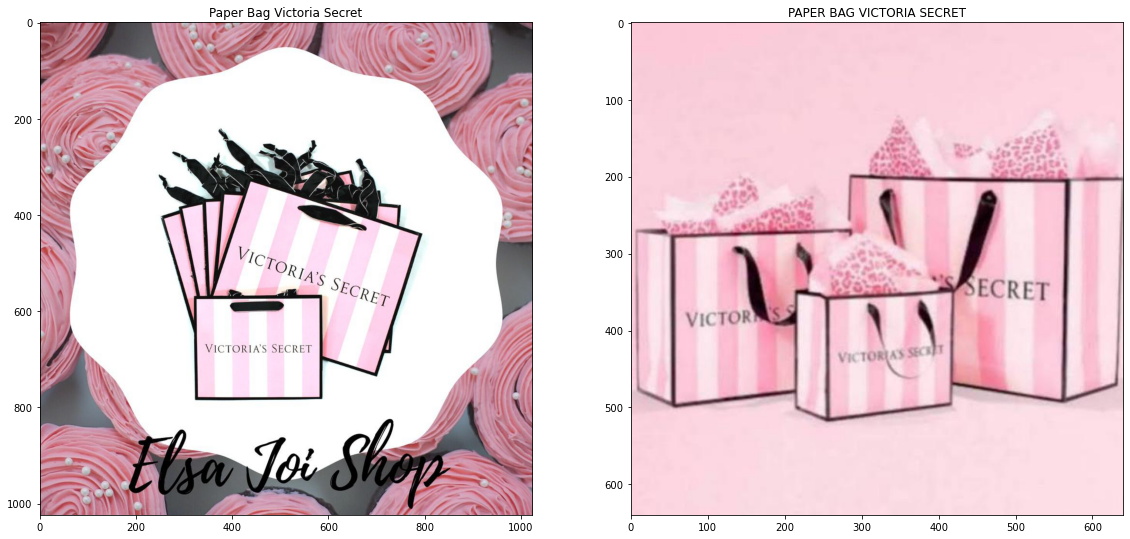

In [47]:
show_images(train, 'train_129225211', matches=True)

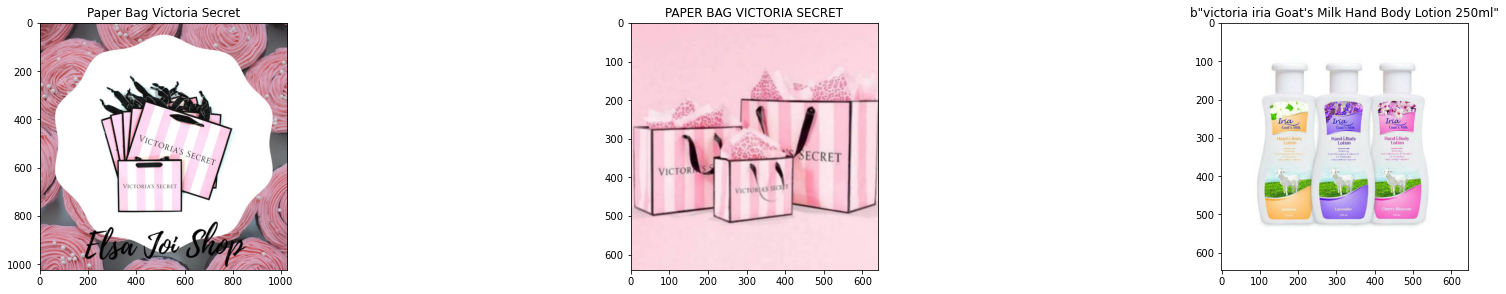

In [48]:
show_images(train, 'train_129225211', matches=False)

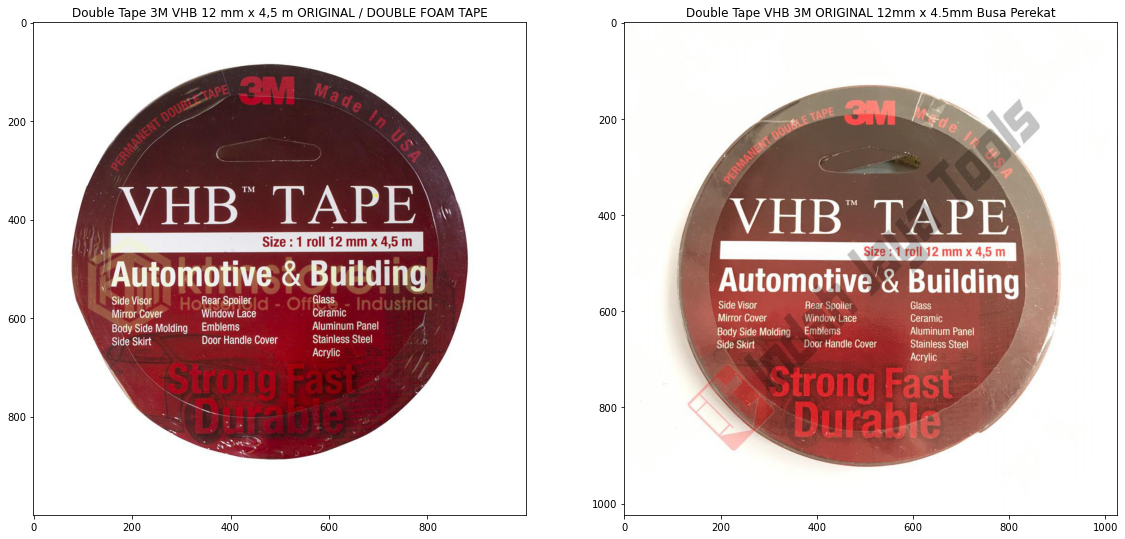

In [49]:
show_images(train, 'train_3386243561', matches=True)

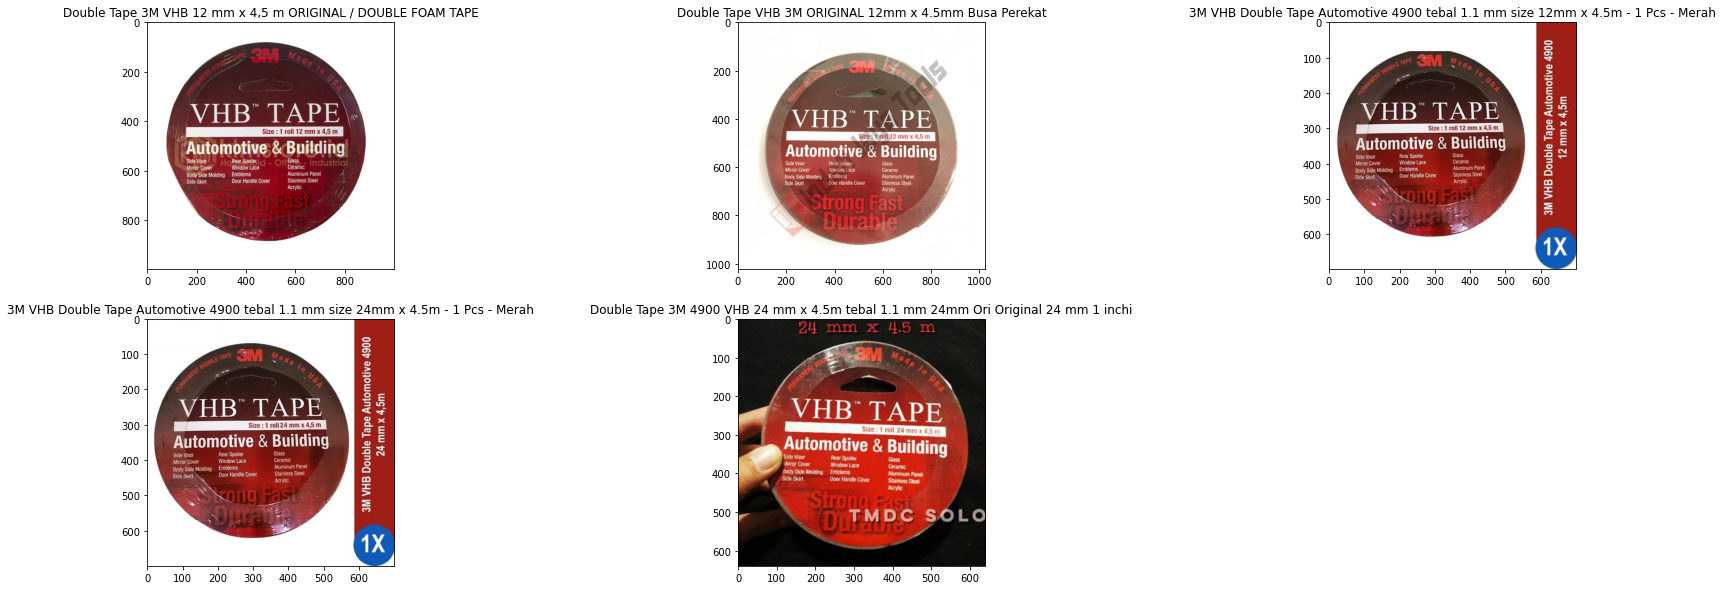

In [50]:
show_images(train, 'train_3386243561', matches=False)

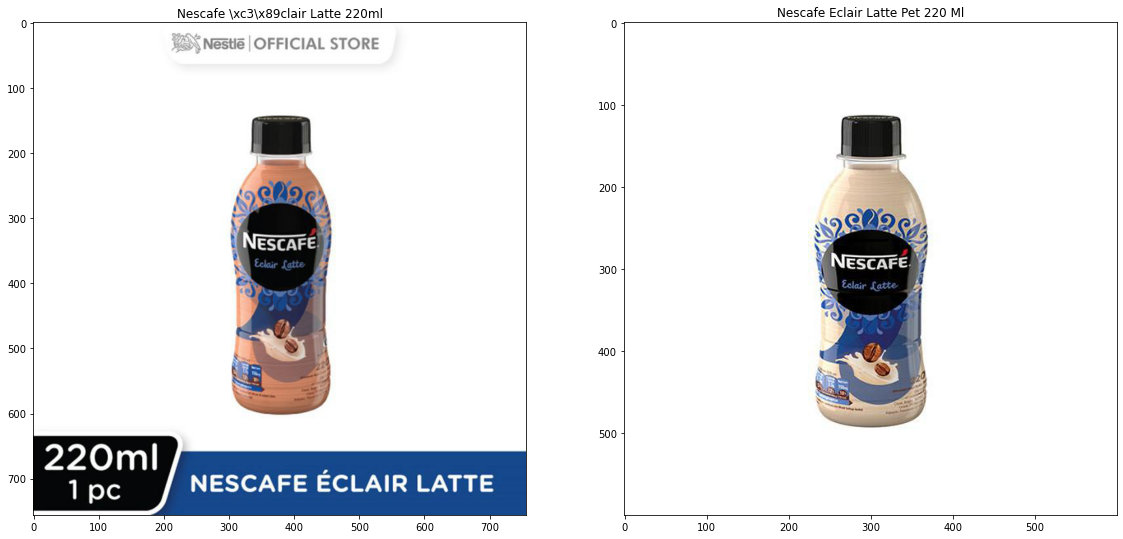

In [51]:
show_images(train, 'train_3369186413', matches=True)

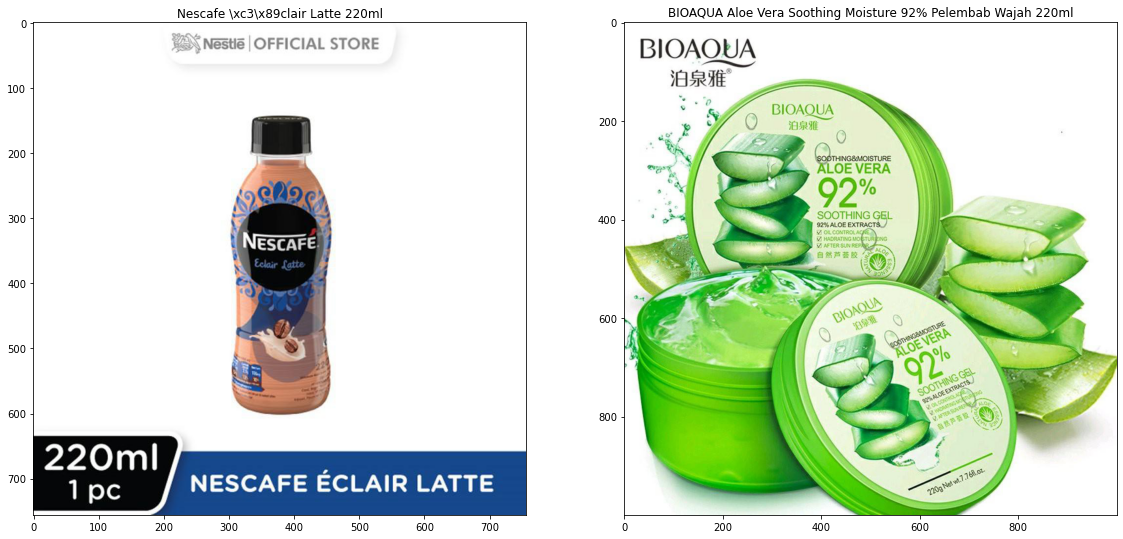

In [52]:
show_images(train, 'train_3369186413', matches=False)

### Concatenate Image, TF_IDF, Semantic Embeddings

In [3]:
# Load best image/text embeddings
image_embeddings = np.load('../datasets/train_image_embeddings_8.npy', allow_pickle=True)
text_embeddings = scipy.sparse.load_npz('../datasets/train_text_embeddings.npz')
text_labse_embeddings = np.load('../datasets/text_labse_embeddings_2.npy', allow_pickle=True)

In [4]:
combined_embeddings = scipy.sparse.hstack((image_embeddings,text_embeddings, text_labse_embeddings))

In [5]:
combined_embeddings.shape

(34250, 27583)

In [6]:
ss = StandardScaler(with_mean=False)

In [7]:
combined_embeddings_scaled = ss.fit_transform(combined_embeddings)

In [8]:
nn = NearestNeighbors(n_neighbors=51, n_jobs=-1, metric = 'cosine')

In [9]:
nn.fit(combined_embeddings_scaled)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=51)

In [10]:
distances, indices = nn.kneighbors(combined_embeddings_scaled)

In [11]:
np.mean([dist.mean() for dist in distances])

0.7708831003432234

In [14]:
ratios = np.linspace(0,0.8,20)

In [15]:
for ratio in ratios:
    preds = []

    for i in range(train.shape[0]):  
        threshold = ratio * np.mean(distances[i])
        idx = indices[i][np.where(distances[i] <= threshold)]
        ids = train['posting_id'].iloc[idx].values
        preds.append(ids)
    print(f'At ratio {ratio}, mean F1 score is {np.mean(scores(matches,preds))}')

At ratio 0.0, mean F1 score is 0.23780652187785523
At ratio 0.042105263157894736, mean F1 score is 0.4875012084667181
At ratio 0.08421052631578947, mean F1 score is 0.5072731640446534
At ratio 0.12631578947368421, mean F1 score is 0.5245021242327158
At ratio 0.16842105263157894, mean F1 score is 0.5391447282148725
At ratio 0.21052631578947367, mean F1 score is 0.5523149393830737
At ratio 0.25263157894736843, mean F1 score is 0.5644360958717007
At ratio 0.29473684210526313, mean F1 score is 0.5749593786333642
At ratio 0.3368421052631579, mean F1 score is 0.5852286949268372
At ratio 0.37894736842105264, mean F1 score is 0.5938360564348324
At ratio 0.42105263157894735, mean F1 score is 0.601804181338122
At ratio 0.4631578947368421, mean F1 score is 0.6110419937906072
At ratio 0.5052631578947369, mean F1 score is 0.6186323821122602
At ratio 0.5473684210526316, mean F1 score is 0.6247537210135644
At ratio 0.5894736842105263, mean F1 score is 0.6302200889627343
At ratio 0.631578947368421, me

In [16]:
thresholds = np.linspace(0,0.8,20)

In [17]:
for threshold in thresholds:
    preds = []

    for i in range(train.shape[0]):  
        idx = indices[i][np.where(distances[i] <= threshold)]
        ids = train['posting_id'].iloc[idx].values
        preds.append(ids)
    print(f'At threshold {threshold}, mean F1 score is {np.mean(scores(matches,preds))}')

At threshold 0.0, mean F1 score is 0.23780652187785523
At threshold 0.042105263157894736, mean F1 score is 0.494254199023718
At threshold 0.08421052631578947, mean F1 score is 0.5208415206158188
At threshold 0.12631578947368421, mean F1 score is 0.5421573510131231
At threshold 0.16842105263157894, mean F1 score is 0.5608784887043728
At threshold 0.21052631578947367, mean F1 score is 0.5767535281056478
At threshold 0.25263157894736843, mean F1 score is 0.5901189119919968
At threshold 0.29473684210526313, mean F1 score is 0.601819525355323
At threshold 0.3368421052631579, mean F1 score is 0.6130605718569526
At threshold 0.37894736842105264, mean F1 score is 0.6197951060204125
At threshold 0.42105263157894735, mean F1 score is 0.6261580402295712
At threshold 0.4631578947368421, mean F1 score is 0.6294505518704481
At threshold 0.5052631578947369, mean F1 score is 0.6299246022488371
At threshold 0.5473684210526316, mean F1 score is 0.6255951856567601
At threshold 0.5894736842105263, mean F1

### Concatenate Image, Semantic Embeddings

In [5]:
# Load best image/text embeddings
image_embeddings = np.load('../datasets/train_image_embeddings_8.npy', allow_pickle=True)
text_labse_embeddings = np.load('../datasets/text_labse_embeddings_2.npy', allow_pickle=True)

In [6]:
combined_embeddings = np.concatenate((image_embeddings,text_labse_embeddings) , axis=1)

In [7]:
combined_embeddings.shape

(34250, 2560)

#### SS, with mean = False

In [6]:
ss = StandardScaler(with_mean=False)

In [7]:
combined_embeddings_scaled = ss.fit_transform(combined_embeddings)

In [8]:
nn = NearestNeighbors(n_neighbors=51, n_jobs=-1, metric = 'cosine')

In [9]:
nn.fit(combined_embeddings_scaled)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=51)

In [10]:
distances, indices = nn.kneighbors(combined_embeddings_scaled)

In [15]:
np.mean(distances)

0.48857683

In [13]:
ratios = np.linspace(0,0.8,20)

In [14]:
for ratio in ratios:
    preds = []

    for i in range(train.shape[0]):  
        threshold = ratio * np.mean(distances[i])
        idx = indices[i][np.where(distances[i] <= threshold)]
        ids = train['posting_id'].iloc[idx].values
        preds.append(ids)
    print(f'At ratio {ratio}, mean F1 score is {np.mean(scores(matches,preds))}')

At ratio 0.0, mean F1 score is 0.26977664897678305
At ratio 0.042105263157894736, mean F1 score is 0.4752849156957254
At ratio 0.08421052631578947, mean F1 score is 0.4958393939553481
At ratio 0.12631578947368421, mean F1 score is 0.5200494185312229
At ratio 0.16842105263157894, mean F1 score is 0.5453462027590203
At ratio 0.21052631578947367, mean F1 score is 0.5715069554302742
At ratio 0.25263157894736843, mean F1 score is 0.5962155357081359
At ratio 0.29473684210526313, mean F1 score is 0.6195263313335633
At ratio 0.3368421052631579, mean F1 score is 0.6409417526586747
At ratio 0.37894736842105264, mean F1 score is 0.6599817514751217
At ratio 0.42105263157894735, mean F1 score is 0.677276036861643
At ratio 0.4631578947368421, mean F1 score is 0.6940805850758001
At ratio 0.5052631578947369, mean F1 score is 0.7100578097484396
At ratio 0.5473684210526316, mean F1 score is 0.7249165595575173
At ratio 0.5894736842105263, mean F1 score is 0.7393096780365479
At ratio 0.631578947368421, me

In [16]:
thresholds = np.linspace(0,0.6,20)

In [17]:
for threshold in thresholds:
    preds = []

    for i in range(train.shape[0]):  
        idx = indices[i][np.where(distances[i] <= threshold)]
        ids = train['posting_id'].iloc[idx].values
        preds.append(ids)
    print(f'At threshold {threshold}, mean F1 score is {np.mean(scores(matches,preds))}')

At threshold 0.0, mean F1 score is 0.26977664897678305
At threshold 0.031578947368421054, mean F1 score is 0.48791931693397694
At threshold 0.06315789473684211, mean F1 score is 0.5265675038812772
At threshold 0.09473684210526316, mean F1 score is 0.5682669786568317
At threshold 0.12631578947368421, mean F1 score is 0.607431701912923
At threshold 0.15789473684210525, mean F1 score is 0.6419015808030917
At threshold 0.18947368421052632, mean F1 score is 0.6716207912974265
At threshold 0.2210526315789474, mean F1 score is 0.6970072728303899
At threshold 0.25263157894736843, mean F1 score is 0.7208945269248405
At threshold 0.28421052631578947, mean F1 score is 0.7394649644928187
At threshold 0.3157894736842105, mean F1 score is 0.7535812191071012
At threshold 0.3473684210526316, mean F1 score is 0.758180008190742
At threshold 0.37894736842105264, mean F1 score is 0.7464969641945904
At threshold 0.4105263157894737, mean F1 score is 0.7150862714722088
At threshold 0.4421052631578948, mean F

#### No SS

In [18]:
nn_2 = NearestNeighbors(n_neighbors=51, n_jobs=-1, metric = 'cosine')

In [19]:
nn_2.fit(combined_embeddings)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=51)

In [20]:
distances_2, indices_2 = nn_2.kneighbors(combined_embeddings)

In [21]:
np.mean(distances_2)

0.39913586

In [22]:
ratios = np.linspace(0,0.8,20)

In [23]:
for ratio in ratios:
    preds = []

    for i in range(train.shape[0]):  
        threshold = ratio * np.mean(distances_2[i])
        idx = indices_2[i][np.where(distances_2[i] <= threshold)]
        ids = train['posting_id'].iloc[idx].values
        preds.append(ids)
    print(f'At ratio {ratio}, mean F1 score is {np.mean(scores(matches,preds))}')

At ratio 0.0, mean F1 score is 0.31808983684795505
At ratio 0.042105263157894736, mean F1 score is 0.5749017093121012
At ratio 0.08421052631578947, mean F1 score is 0.6016931730493424
At ratio 0.12631578947368421, mean F1 score is 0.6181077902979087
At ratio 0.16842105263157894, mean F1 score is 0.6304805415777472
At ratio 0.21052631578947367, mean F1 score is 0.6417106933937381
At ratio 0.25263157894736843, mean F1 score is 0.6511092479117749
At ratio 0.29473684210526313, mean F1 score is 0.6600799572717155
At ratio 0.3368421052631579, mean F1 score is 0.669009310163363
At ratio 0.37894736842105264, mean F1 score is 0.6774813969778011
At ratio 0.42105263157894735, mean F1 score is 0.6848522135037212
At ratio 0.4631578947368421, mean F1 score is 0.6927314424784713
At ratio 0.5052631578947369, mean F1 score is 0.700057349231944
At ratio 0.5473684210526316, mean F1 score is 0.7065310063111772
At ratio 0.5894736842105263, mean F1 score is 0.712657118586825
At ratio 0.631578947368421, mean

In [24]:
thresholds = np.linspace(0,0.6,20)

In [25]:
for threshold in thresholds:
    preds = []

    for i in range(train.shape[0]):  
        idx = indices_2[i][np.where(distances_2[i] <= threshold)]
        ids = train['posting_id'].iloc[idx].values
        preds.append(ids)
    print(f'At threshold {threshold}, mean F1 score is {np.mean(scores(matches,preds))}')

At threshold 0.0, mean F1 score is 0.31808983684795505
At threshold 0.031578947368421054, mean F1 score is 0.6021432044977616
At threshold 0.06315789473684211, mean F1 score is 0.6307814748044059
At threshold 0.09473684210526316, mean F1 score is 0.6512197514897956
At threshold 0.12631578947368421, mean F1 score is 0.6688406665453572
At threshold 0.15789473684210525, mean F1 score is 0.6847001283111747
At threshold 0.18947368421052632, mean F1 score is 0.6981468545441737
At threshold 0.2210526315789474, mean F1 score is 0.7088841983527187
At threshold 0.25263157894736843, mean F1 score is 0.7117470504382082
At threshold 0.28421052631578947, mean F1 score is 0.70037996737462
At threshold 0.3157894736842105, mean F1 score is 0.6688311171941869
At threshold 0.3473684210526316, mean F1 score is 0.6068622008520802
At threshold 0.37894736842105264, mean F1 score is 0.5093304416778222
At threshold 0.4105263157894737, mean F1 score is 0.39279769315389784
At threshold 0.4421052631578948, mean F

#### SS, with mean = True

In [8]:
ss = StandardScaler()

In [9]:
combined_embeddings_scaled = ss.fit_transform(combined_embeddings)

In [10]:
nn = NearestNeighbors(n_neighbors=51, n_jobs=-1, metric = 'cosine')

In [11]:
nn.fit(combined_embeddings_scaled)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=51)

In [12]:
distances, indices = nn.kneighbors(combined_embeddings_scaled)

In [13]:
np.mean(distances)

0.59598213

In [14]:
ratios = np.linspace(0,0.8,20)

In [15]:
for ratio in ratios:
    preds = []

    for i in range(train.shape[0]):  
        threshold = ratio * np.mean(distances[i])
        idx = indices[i][np.where(distances[i] <= threshold)]
        ids = train['posting_id'].iloc[idx].values
        preds.append(ids)
    print(f'At ratio {ratio}, mean F1 score is {np.mean(scores(matches,preds))}')

At ratio 0.0, mean F1 score is 0.2615924413743011
At ratio 0.042105263157894736, mean F1 score is 0.4753907928417761
At ratio 0.08421052631578947, mean F1 score is 0.49617186813369984
At ratio 0.12631578947368421, mean F1 score is 0.5201976955266921
At ratio 0.16842105263157894, mean F1 score is 0.5459132919522726
At ratio 0.21052631578947367, mean F1 score is 0.5722527375174262
At ratio 0.25263157894736843, mean F1 score is 0.5969567461415287
At ratio 0.29473684210526313, mean F1 score is 0.6198500356062869
At ratio 0.3368421052631579, mean F1 score is 0.6413734887393617
At ratio 0.37894736842105264, mean F1 score is 0.6605637106688605
At ratio 0.42105263157894735, mean F1 score is 0.6782464974647555
At ratio 0.4631578947368421, mean F1 score is 0.694446225599894
At ratio 0.5052631578947369, mean F1 score is 0.710333151281226
At ratio 0.5473684210526316, mean F1 score is 0.7252142336783794
At ratio 0.5894736842105263, mean F1 score is 0.7390410137513742
At ratio 0.631578947368421, mea

In [16]:
thresholds = np.linspace(0,0.6,20)

In [17]:
for threshold in thresholds:
    preds = []

    for i in range(train.shape[0]):  
        idx = indices[i][np.where(distances[i] <= threshold)]
        ids = train['posting_id'].iloc[idx].values
        preds.append(ids)
    print(f'At threshold {threshold}, mean F1 score is {np.mean(scores(matches,preds))}')

At threshold 0.0, mean F1 score is 0.2615924413743011
At threshold 0.031578947368421054, mean F1 score is 0.48163336133891205
At threshold 0.06315789473684211, mean F1 score is 0.5116176453233574
At threshold 0.09473684210526316, mean F1 score is 0.5464185808793139
At threshold 0.12631578947368421, mean F1 score is 0.5805756146640684
At threshold 0.15789473684210525, mean F1 score is 0.6121319381217409
At threshold 0.18947368421052632, mean F1 score is 0.6397443650009277
At threshold 0.2210526315789474, mean F1 score is 0.6647845843788049
At threshold 0.25263157894736843, mean F1 score is 0.6870188296223285
At threshold 0.28421052631578947, mean F1 score is 0.7070355115456567
At threshold 0.3157894736842105, mean F1 score is 0.7244929705917974
At threshold 0.3473684210526316, mean F1 score is 0.7389815166626682
At threshold 0.37894736842105264, mean F1 score is 0.7506789310778236
At threshold 0.4105263157894737, mean F1 score is 0.7559547901685756
At threshold 0.4421052631578948, mean 

## Distances

In [3]:
# Load train data with matches and image duplicates
train = pd.DataFrame(np.load('../datasets/train.npy', allow_pickle=True),
                     columns=['posting_id', 'image', 'image_phash', 'title', 'label_group', 'matches', 'image_duplicates'])

In [4]:
# Load image/text distances and indices
image_distances = np.load('../datasets/best_image_distances_cosine.npy')
image_indices = np.load('../datasets/best_image_indices_cosine.npy')

text_distances = np.load('../datasets/best_text_distances.npy')
text_indices = np.load('../datasets/best_text_indices.npy')

In [29]:
# Load best image/text embeddings
image_embeddings = np.load('../datasets/train_image_embeddings_3.npy', allow_pickle=True)
text_embeddings = scipy.sparse.load_npz('../datasets/train_text_embeddings.npz')

In [5]:
unique_indices = np.unique(np.concatenate([pred[1:] for pred in image_indices]))

In [6]:
len(unique_indices)

34236

In [7]:
image_distances

array([[-1.1920929e-07,  4.1093123e-01,  4.1276455e-01, ...,
         4.9654227e-01,  4.9735874e-01,  4.9858332e-01],
       [ 9.5367432e-07,  1.1630225e-01,  1.2703323e-01, ...,
         4.4795626e-01,  4.4955188e-01,  4.4978803e-01],
       [-2.3841858e-07,  3.8687837e-01,  4.0672576e-01, ...,
         5.0475633e-01,  5.0493580e-01,  5.0506645e-01],
       ...,
       [ 3.5762787e-07,  4.8220217e-02,  5.2026510e-02, ...,
         4.3173939e-01,  4.3206316e-01,  4.3282115e-01],
       [-1.1920929e-07,  1.3380766e-02,  1.6835093e-02, ...,
         4.3838263e-01,  4.3848002e-01,  4.4017625e-01],
       [-7.1525574e-07,  6.1969876e-02,  2.4283636e-01, ...,
         3.5309196e-01,  3.5342383e-01,  3.5393864e-01]], dtype=float32)

In [8]:
image_distances[:, 1:]

array([[0.41093123, 0.41276455, 0.45643562, ..., 0.49654227, 0.49735874,
        0.49858332],
       [0.11630225, 0.12703323, 0.13027668, ..., 0.44795626, 0.44955188,
        0.44978803],
       [0.38687837, 0.40672576, 0.4211355 , ..., 0.50475633, 0.5049358 ,
        0.50506645],
       ...,
       [0.04822022, 0.05202651, 0.05202651, ..., 0.4317394 , 0.43206316,
        0.43282115],
       [0.01338077, 0.01683509, 0.3596263 , ..., 0.43838263, 0.43848002,
        0.44017625],
       [0.06196988, 0.24283636, 0.25333464, ..., 0.35309196, 0.35342383,
        0.35393864]], dtype=float32)

In [9]:
image_distances[:, 1:].shape

(34250, 50)

In [15]:
image_distances_df = pd.DataFrame(image_distances[:, 1:])
image_distances_df.head()

0         1         2         3         4         5         6   \
0  0.410931  0.412765  0.456436  0.457608  0.458004  0.459985  0.460107   
1  0.116302  0.127033  0.130277  0.184154  0.227044  0.274436  0.310827   
2  0.386878  0.406726  0.421135  0.424342  0.429384  0.431355  0.432215   
3  0.157352  0.166495  0.168247  0.185033  0.225667  0.225667  0.233662   
4  0.130570  0.240401  0.262815  0.266397  0.321650  0.330697  0.330720   

         7         8         9   ...        40        41        42        43  \
0  0.462313  0.464054  0.466457  ...  0.489165  0.489892  0.494577  0.495287   
1  0.338411  0.354782  0.360020  ...  0.428812  0.430713  0.433522  0.436879   
2  0.432304  0.432712  0.441962  ...  0.498918  0.499364  0.499371  0.499384   
3  0.237575  0.237575  0.238008  ...  0.375236  0.375236  0.375236  0.375236   
4  0.335788  0.340991  0.354923  ...  0.397923  0.398147  0.399504  0.400526   

         44        45        46        47        48        49  
0  0.495508  0.496359  0.496359  0.496542  0.497359  0.498583  
1  0.436954  0.439051  0.442393  0.447956  0.449552  0.449788  
2  0.500159  0.501226  0.502705  0.504756  0.504936  0.505066  
3  0.375236  0.375236  0.375982  0.376250  0.378731  0.379262  
4  0.401201  0.401790  0.402332  0.404023  0.404297  0.404884  

[5 rows x 50 columns]

In [22]:
image_distances_df['avg_distance'] = image_distances_df.mean(axis=1)

In [23]:
image_distances_df.head()

0         1         2         3         4         5         6  \
0  0.410931  0.412765  0.456436  0.457608  0.458004  0.459985  0.460107   
1  0.116302  0.127033  0.130277  0.184154  0.227044  0.274436  0.310827   
2  0.386878  0.406726  0.421135  0.424342  0.429384  0.431355  0.432215   
3  0.157352  0.166495  0.168247  0.185033  0.225667  0.225667  0.233662   
4  0.130570  0.240401  0.262815  0.266397  0.321650  0.330697  0.330720   

          7         8         9  ...        41        42        43        44  \
0  0.462313  0.464054  0.466457  ...  0.489892  0.494577  0.495287  0.495508   
1  0.338411  0.354782  0.360020  ...  0.430713  0.433522  0.436879  0.436954   
2  0.432304  0.432712  0.441962  ...  0.499364  0.499371  0.499384  0.500159   
3  0.237575  0.237575  0.238008  ...  0.375236  0.375236  0.375236  0.375236   
4  0.335788  0.340991  0.354923  ...  0.398147  0.399504  0.400526  0.401201   

         45        46        47        48        49  avg_distance  
0  0.496359  0.496359  0.496542  0.497359  0.498583      0.470723  
1  0.439051  0.442393  0.447956  0.449552  0.449788      0.377676  
2  0.501226  0.502705  0.504756  0.504936  0.505066      0.464437  
3  0.375236  0.375982  0.376250  0.378731  0.379262      0.303746  
4  0.401790  0.402332  0.404023  0.404297  0.404884      0.364710  

[5 rows x 51 columns]

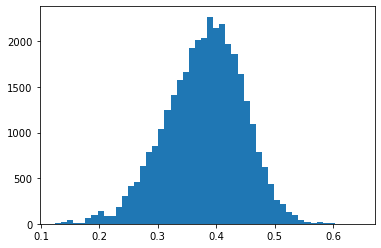

In [27]:
plt.hist(image_distances_df['avg_distance'], bins = 50);

In [30]:
# Generate image distances of actual product matches
actual_image_distances = []
for i in range(train.shape[0]):
    distances = []
    matches = train['matches'].iloc[i]
    
    # Obtain indexes of matches
    for match in matches:
        match_idx = train[train['posting_id'] == match].index.values[0]
        
        # Calculate cosine distance of matches to product
        distances.append(distance.cosine(image_embeddings[i], image_embeddings[match_idx]))
    
    actual_image_distances.append(distances)

In [31]:
actual_image_distances

[[0.0, 0.5923837721347809],
 [0.0, 0.11630195379257202],
 [0.0, 0.5271739959716797],
 [0.0, 0.46964138746261597],
 [0.0, 0.13056975603103638],
 [0.0, 0.0035437345504760742, 0.46426546573638916],
 [0.0,
  0.5105242133140564,
  0.6859883069992065,
  0.7155195474624634,
  0.5002162754535675,
  0.689635843038559,
  0.6460192501544952],
 [0.0, 0.3942667841911316],
 [0.0, 0.04394114017486572, 0.04394114017486572],
 [0.0, 0.09375673532485962],
 [0.0, 0.3472093939781189, 0.3472093939781189],
 [0.0, 0.0, 0.8521421104669571],
 [0.0, 0.0, 0.8521421104669571],
 [0.0, 0.3322482705116272],
 [0.0, 0.0006281733512878418, 0.0006281733512878418],
 [0.0,
  0.3273324966430664,
  0.37041378021240234,
  0.0012052655220031738,
  0.006171882152557373,
  0.3203830122947693,
  0.32646864652633667,
  0.28841865062713623],
 [0.0, 0.20871955156326294],
 [0.0, 0.33042532205581665],
 [0.0, 0.00748753547668457, 0.007094085216522217],
 [0.0,
  0.013066470623016357,
  0.6073772609233856,
  0.03993147611618042,
  0.3965

In [32]:
image_distances_df['actual_avg_distance'] = [np.mean(dists) for dists in actual_image_distances]

In [34]:
image_distances_df['actual_max_distance'] = [np.max(dists) for dists in actual_image_distances]

In [35]:
image_distances_df[['avg_distance', 'actual_max_distance', 'actual_avg_distance']]

avg_distance  actual_max_distance  actual_avg_distance
0          0.470723             0.592384             0.296192
1          0.377676             0.116302             0.058151
2          0.464437             0.527174             0.263587
3          0.303746             0.469641             0.234821
4          0.364710             0.130570             0.065285
...             ...                  ...                  ...
34245      0.516004             0.732504             0.366252
34246      0.277047             0.106142             0.053071
34247      0.333478             0.618627             0.202752
34248      0.396821             0.016835             0.010072
34249      0.311242             0.061970             0.030985

[34250 rows x 3 columns]

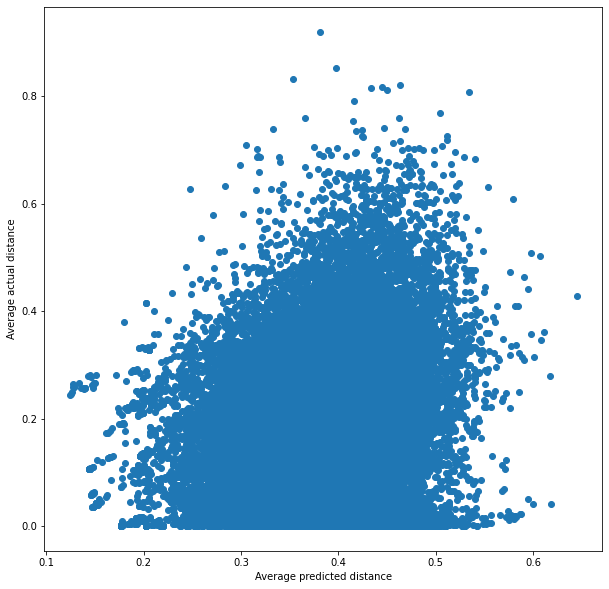

In [40]:
plt.figure(figsize=(10,10))
plt.scatter(x=image_distances_df['avg_distance'], y=image_distances_df['actual_avg_distance'])
plt.xlabel('Average predicted distance')
plt.ylabel('Average actual distance');

In [10]:
image_indices[:, 1:]

array([[ 8718, 19243, 34183, ..., 28707, 25358,  1805],
       [18683,   194,   469, ..., 16312,  8807,  1225],
       [27518,  9220, 23583, ..., 17835, 13272,  3461],
       ...,
       [23056, 18380, 18379, ..., 21047, 20913,  1446],
       [13887, 20813, 16230, ..., 18190, 23050, 21977],
       [33792, 21025, 17962, ...,  5326, 27748,  8628]], dtype=int64)

In [11]:
image_indices[:, 1:].shape

(34250, 50)

In [66]:
indices = np.array([[i]*50 for i in range(34250)])

In [67]:
indices.shape

(34250, 50)

In [68]:
combined = np.dstack((image_distances[:, 1:],
                      np.dstack((image_indices[:, 1:], indices))
                     ))

In [69]:
combined[0]

array([[4.10931230e-01, 8.71800000e+03, 0.00000000e+00],
       [4.12764549e-01, 1.92430000e+04, 0.00000000e+00],
       [4.56435621e-01, 3.41830000e+04, 0.00000000e+00],
       [4.57608223e-01, 2.89800000e+03, 0.00000000e+00],
       [4.58003581e-01, 2.26140000e+04, 0.00000000e+00],
       [4.59985018e-01, 2.32410000e+04, 0.00000000e+00],
       [4.60107446e-01, 3.17300000e+03, 0.00000000e+00],
       [4.62313116e-01, 9.21900000e+03, 0.00000000e+00],
       [4.64054465e-01, 1.10870000e+04, 0.00000000e+00],
       [4.66456950e-01, 3.00130000e+04, 0.00000000e+00],
       [4.67355490e-01, 1.75080000e+04, 0.00000000e+00],
       [4.71421719e-01, 6.26000000e+02, 0.00000000e+00],
       [4.73475754e-01, 8.38200000e+03, 0.00000000e+00],
       [4.73951221e-01, 2.66710000e+04, 0.00000000e+00],
       [4.74494994e-01, 3.03410000e+04, 0.00000000e+00],
       [4.74496722e-01, 2.84220000e+04, 0.00000000e+00],
       [4.75426078e-01, 2.93160000e+04, 0.00000000e+00],
       [4.76189792e-01, 3.02410

In [70]:
all_image_predictions = np.concatenate(combined)

In [71]:
all_image_predictions

array([[4.10931230e-01, 8.71800000e+03, 0.00000000e+00],
       [4.12764549e-01, 1.92430000e+04, 0.00000000e+00],
       [4.56435621e-01, 3.41830000e+04, 0.00000000e+00],
       ...,
       [3.53091955e-01, 5.32600000e+03, 3.42490000e+04],
       [3.53423834e-01, 2.77480000e+04, 3.42490000e+04],
       [3.53938639e-01, 8.62800000e+03, 3.42490000e+04]])

In [72]:
all_image_predictions.shape

(1712500, 3)

In [73]:
all_image_predictions = all_image_predictions[all_image_predictions[:, 0].argsort()]

In [75]:
all_image_predictions

array([[-1.78813934e-06,  2.76750000e+04,  2.76760000e+04],
       [-1.78813934e-06,  2.76750000e+04,  2.76750000e+04],
       [-1.54972076e-06,  2.55880000e+04,  2.55870000e+04],
       ...,
       [ 7.36591816e-01,  1.87680000e+04,  1.41500000e+04],
       [ 7.36716390e-01,  1.63120000e+04,  1.41500000e+04],
       [ 7.37656593e-01,  1.44850000e+04,  1.41500000e+04]])

In [76]:
predictions = [[i] for i in range(34250)]

In [77]:
predictions

[[0],
 [1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9],
 [10],
 [11],
 [12],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25],
 [26],
 [27],
 [28],
 [29],
 [30],
 [31],
 [32],
 [33],
 [34],
 [35],
 [36],
 [37],
 [38],
 [39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [55],
 [56],
 [57],
 [58],
 [59],
 [60],
 [61],
 [62],
 [63],
 [64],
 [65],
 [66],
 [67],
 [68],
 [69],
 [70],
 [71],
 [72],
 [73],
 [74],
 [75],
 [76],
 [77],
 [78],
 [79],
 [80],
 [81],
 [82],
 [83],
 [84],
 [85],
 [86],
 [87],
 [88],
 [89],
 [90],
 [91],
 [92],
 [93],
 [94],
 [95],
 [96],
 [97],
 [98],
 [99],
 [100],
 [101],
 [102],
 [103],
 [104],
 [105],
 [106],
 [107],
 [108],
 [109],
 [110],
 [111],
 [112],
 [113],
 [114],
 [115],
 [116],
 [117],
 [118],
 [119],
 [120],
 [121],
 [122],
 [123],
 [124],
 [125],
 [126],
 [127],
 [128],
 [129],
 [130],
 [131],
 [132],
 [133],
 [134],
 [135],
 [136],
 [137],
 [138]

In [78]:
used = []
predictions = [[i] for i in range(34250)]

for pred in all_image_predictions:
    
    prediction = int(pred[1])
    index = int(pred[2])
    
    if prediction in used:
        pass
    
    else:
        predictions[index].append(prediction)       

        used.append(prediction)

In [79]:
predictions

[[0],
 [1, 18683],
 [2],
 [3, 2522, 13324],
 [4, 18449],
 [5, 1442, 9810],
 [6, 32264, 12744],
 [7],
 [8, 4829, 26886],
 [9, 23587, 8455],
 [10, 22612, 30095],
 [11, 12],
 [12],
 [13, 28067],
 [14, 27179, 5256],
 [15, 4656, 26652],
 [16, 22789],
 [17],
 [18],
 [19, 13799, 6925],
 [20],
 [21, 24797],
 [22],
 [23],
 [24, 25635, 8308, 12579, 31570],
 [25, 14547],
 [26],
 [27, 23290],
 [28, 29],
 [29, 31410],
 [30],
 [31],
 [32, 9133],
 [33],
 [34, 4248, 5091],
 [35],
 [36],
 [37, 25287, 25002, 24405],
 [38, 25836],
 [39],
 [40, 3708],
 [41],
 [42, 26662, 12715],
 [43],
 [44, 30270],
 [45],
 [46, 3835, 7393, 14226],
 [47, 15067],
 [48, 29820, 19570, 32341],
 [49, 11952],
 [50, 13644, 34235, 33806],
 [51],
 [52],
 [53, 5154],
 [54, 22945],
 [55, 312, 22139],
 [56, 57, 33527, 16039],
 [57],
 [58, 58],
 [59, 482],
 [60, 23102, 29646],
 [61],
 [62, 20717],
 [63, 8668, 2608, 27146],
 [64, 9032, 20358, 12524, 30333, 23508],
 [65, 19250],
 [66],
 [67],
 [68, 4966, 4238, 24500],
 [69, 12065],
 [70

In [89]:
len(np.concatenate(predictions))

68486

In [81]:
image_predictions = [train['posting_id'].iloc[predictions[i]].values for i in range(34250)]

In [84]:
np.mean(scores(matches,image_predictions))

0.5757663641617535

In [87]:
train['predictions'] = image_predictions
train['f1_scores'] = scores(matches,image_predictions)

In [93]:
train.head(10)

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   
5  train_2464356923  0013e7355ffc5ff8fb1ccad3e42d92fe.jpg  bbd097a7870f4a50   
6  train_1802986387  00144a49c56599d45354a1c28104c039.jpg  f815c9bb833ab4c8   
7  train_1806152124  0014f61389cbaa687a58e38a97b6383d.jpg  eea7e1c0c04da33d   
8    train_86570404  0019a3c6755a194cb2e2c12bfc63972e.jpg  ea9af4f483249972   
9   train_831680791  001be52b2beec40ddc1d2d7fc7a68f08.jpg  e1ce953d1a70618f   

                                               title label_group  \
0                          Paper Bag Victoria Secret   249114794   
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...  2937985045   
2        Maling TTS Canned Pork Luncheon Meat 397 gr  2395904891   
3  Daster Batik Lengan pendek - Motif Acak / Camp...  4093212188   
4                  Nescafe \xc3\x89clair Latte 220ml  3648931069   
5  CELANA WANITA  (BB 45-84 KG)Harem wanita (bisa...  2660605217   
6                           Jubah anak size 1-12 thn  1835033137   
7  KULOT PLISKET SALUR /CANDY PLISKET /WISH KULOT...  1565741687   
8  [LOGU] Tempelan kulkas magnet angka, tempelan ...  2359912463   
9  BIG SALE SEPATU PANTOFEL KULIT KEREN KERJA KAN...  2630990665   

                                             matches  \
0                [train_129225211, train_2278313361]   
1               [train_3386243561, train_3423213080]   
2               [train_2288590299, train_3803689425]   
3               [train_2406599165, train_3342059966]   
4                [train_3369186413, train_921438619]   
5  [train_2464356923, train_2753295474, train_305...   
6  [train_1802986387, train_1396161074, train_713...   
7               [train_1806152124, train_3227306976]   
8  [train_86570404, train_2837452969, train_77364...   
9                [train_831680791, train_3031035861]   

                       image_duplicates  \
0                     [train_129225211]   
1                    [train_3386243561]   
2                    [train_2288590299]   
3                    [train_2406599165]   
4                    [train_3369186413]   
5  [train_2464356923, train_2753295474]   
6                    [train_1802986387]   
7                    [train_1806152124]   
8                      [train_86570404]   
9                     [train_831680791]   

                                         predictions  f1_scores  
0                                  [train_129225211]   0.666667  
1               [train_3386243561, train_3423213080]   1.000000  
2                                 [train_2288590299]   0.666667  
3  [train_2406599165, train_3576714541, train_353...   0.400000  
4                [train_3369186413, train_921438619]   1.000000  
5  [train_2464356923, train_2753295474, train_373...   0.666667  
6  [train_1802986387, train_1513994777, train_944...   0.200000  
7                                 [train_1806152124]   0.666667  
8  [train_86570404, train_77364776, train_115157077]   0.666667  
9  [train_831680791, train_3031035861, train_1480...   0.800000

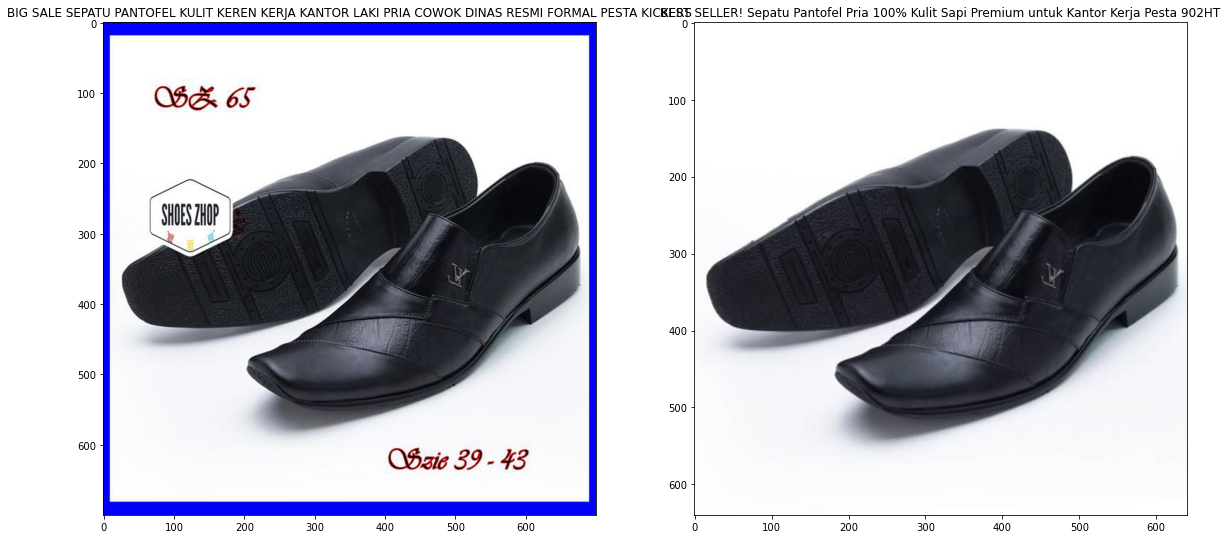

In [94]:
show_images(train, 'train_831680791', matches=True)

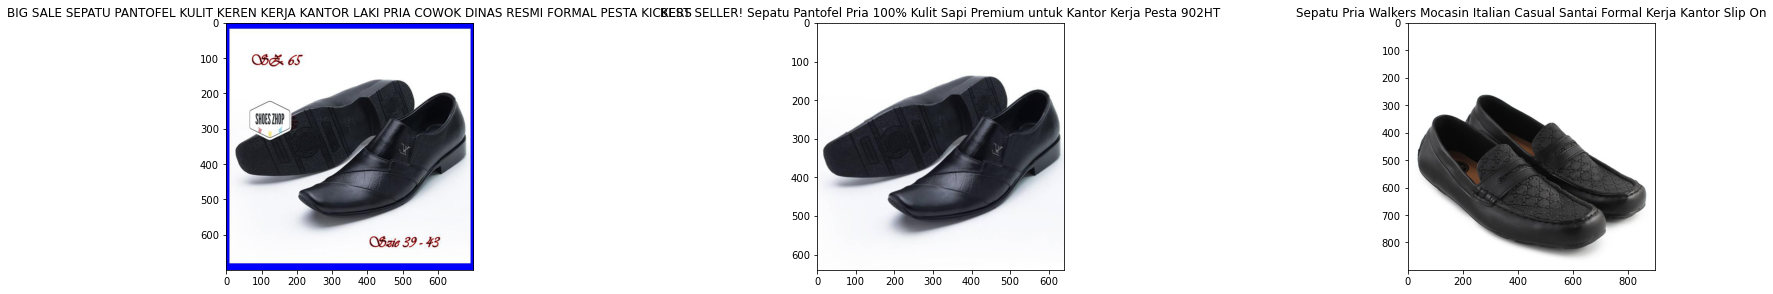

In [95]:
show_images(train, 'train_831680791', matches=False)

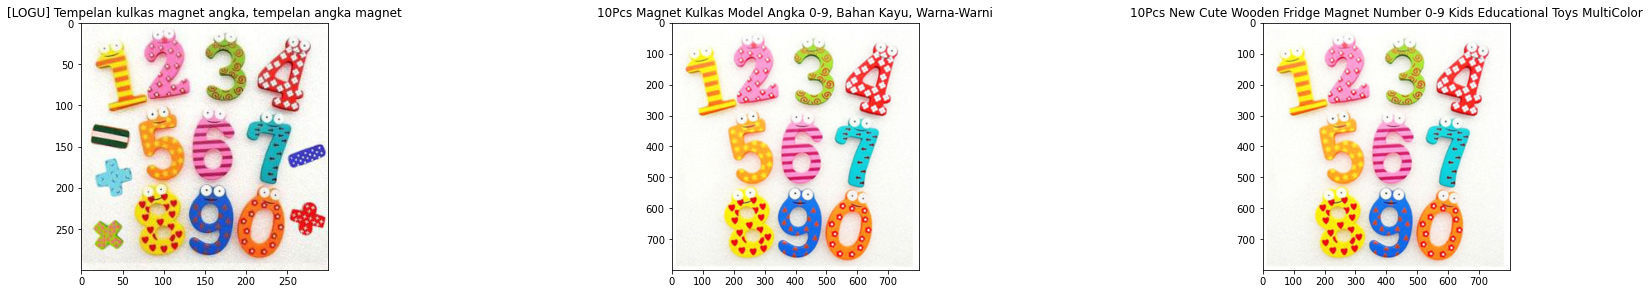

In [96]:
show_images(train, 'train_86570404', matches=True)

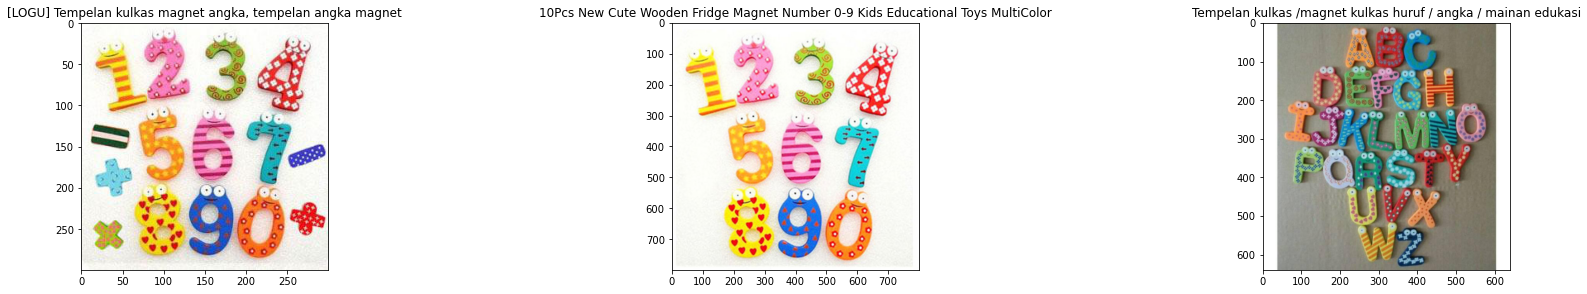

In [97]:
show_images(train, 'train_86570404', matches=False)